In [1]:
import argparse, random, os
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from clip_illusion import Illusion
from utils.model_utils import load_vision_model
from utils.objectives import ClassConditionalObjective
from utils.config import Domain2Dict
from utils.feature_manipulation import counterfactual_explanation
from train_test_classifier import load_test_data, eval_loop, load_datasets
from scripts.inspect_class_mistakes import inspect_mistakes_in_class, vote_topk, aggregate_vote

In [2]:
domain_name = "food"
class_dict = Domain2Dict[domain_name]

def prepare_model_and_illusion(model_name, device_id, class_gamma=0.35, domain_eps=0.05, ckpt_path=None, is_vit=False):
    device = torch.device(f"cuda:{device_id}")
    transform, model, pool, decision, config = load_vision_model(model_name, device=device, ckpt_path=ckpt_path)
    illusion = Illusion(model, decision, ClassConditionalObjective(image_size=224, class_gamma=class_gamma, domain_eps=domain_eps, is_vit=is_vit, wo_clip=False), \
        class_dict=class_dict, device=f"cuda:{device_id}", img_mean=config["mean"], img_std=config["std"])
    
    return model, illusion, {"transform": transform, "pool": pool, "decision": decision}

def inference_one_sample(model, image_path, device):
    image = Image.open(image_path).convert("RGB")
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0).to(device)
    
    logits = model(image)
    pred = torch.argmax(logits, dim=-1)[0].item()
    
    return pred

In [3]:
device_id = 0
class_gamma = 0.4
domain_eps = 0.05
model_name = "resnet50"
dataset_name = "food101"
ckpt_path = f"ckpt/{dataset_name}_resnet50/best_model.pt" # best_91.33.pt
batch_size = 64
device = torch.device(device_id)

# Prepare model and CLIP-Illusion
model = torch.load(ckpt_path).to(f"cuda:{device_id}")
model, illusion, modules = prepare_model_and_illusion(model_name, device_id, class_gamma, domain_eps, ckpt_path, is_vit="vit" in model_name)
dimension = modules["decision"].weight.data.shape[1]

In [4]:
data_dir= "data"

class_idx = 93
# Prepare validation dataset
valid_dataset, classes = load_test_data(dataset_name, data_dir, batch_size, split="valid")
print("> The number of test samples: %d" % len(valid_dataset))
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

if dataset_name in ["imagenet", "typographic"]:
    img_filelist = valid_dataset.samples
else:
    img_filelist = valid_dataset._image_files

> The number of test samples: 9595


In [5]:
# Test the model
mistake_samples, mislabels, correct_labels, imp, class_features = inspect_mistakes_in_class(len(classes), test_loader, img_filelist, model, device, class_idx=class_idx, decision=modules["decision"])
num_mistakes = len(mistake_samples)
print(f"> {model_name} has {num_mistakes} mistakes for the {dataset_name} dataset.")

Evaluating: 150it [00:18,  8.31it/s]

> resnet50 has 53 mistakes for the food101 dataset.


In [6]:
class_dict = Domain2Dict[domain_name]
if class_idx is not None:
    class_name = class_dict[class_idx].split(", ")[-1]
else:
    class_name = "all"
    
folder_class_name = class_name.replace(" ", "_")
exp_name = f"debug_{model_name}_{dataset_name}_{folder_class_name}"

# Counterfactual explanation
print(f"> Inspecting mistakes for {class_name}...")
adjust_w = counterfactual_explanation(mistake_samples, modules["transform"], model, modules["pool"], modules["decision"], \
                                    device, class_idx=class_idx, correct_labels=correct_labels)

> Inspecting mistakes for steak...


Progress 100.00 Optimizing iteration: 4, top neuron: 426    


In [7]:
pos_vote = vote_topk(adjust_w, neg=False, k=5)
neg_vote = vote_topk(adjust_w, neg=True, k=5)
total_topk_pos = aggregate_vote(pos_vote, adjust_w.shape[0], cut_ratio=0.0)
total_topk_neg = aggregate_vote(neg_vote, adjust_w.shape[0])
pos_ids = total_topk_pos.keys()
neg_ids = total_topk_neg.keys()

print("\n<Underlying Reasons>")
    
print("\n- Insufficient Properties:")
print(" Rank    ID  Prec@5 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_pos.items()):
    if n_id in neg_ids:
        skip+=1
        continue
    if r >= 30:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, 1.0 if imp is None else imp[n_id]))
print("--------------------------------")
        
print("\n- Excessive Properties:")
print(" Rank    ID  Prec@5 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_neg.items()):
    if n_id in pos_ids:
        skip+=1
        continue
    if r >= 30:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, 1.0 if imp is None else imp[n_id]))
print("--------------------------------\n")


<Underlying Reasons>

- Insufficient Properties:
 Rank    ID  Prec@5 %  Importance
--------------------------------
Top-1: 1256  57.447   1.0883
Top-2: 1239  44.681   1.0320
Top-3: 1039  44.681   1.1005
Top-4: 1172  40.426   1.0629
Top-5: 1336  36.170   1.0686
Top-6:  974  23.404   1.0973
Top-7:  572  17.021   1.0587
Top-8:  341  12.766   1.0366
Top-9: 1890  10.638   1.0821
Top-10:  507  10.638   1.1130
Top-11:  443  10.638   1.1052
Top-12: 1848  10.638   1.0883
Top-13: 1780  10.638   1.1109
Top-14:  807  10.638   1.0444
Top-15: 1238  8.511   1.0262
Top-16: 1639  6.383   1.0583
Top-17:   83  6.383   1.1121
Top-18: 1058  6.383   1.0744
Top-19: 1475  4.255   1.0186
Top-20:  962  4.255   1.0631
Top-21:  426  4.255   1.0710
Top-22: 1276  4.255   1.0591
Top-23: 1549  4.255   1.0650
Top-24:  268  4.255   1.1154
Top-25:  533  4.255   1.0873
Top-26: 1869  4.255   1.1151
Top-27:  117  4.255   1.0984
Top-28: 1335  4.255   1.0884
Top-29: 1800  4.255   1.0501
Top-30: 1275  4.255   1.0495
--------

In [8]:
neurons = list(total_topk_pos.keys())[:30] # or [chosen neuron ids]
target_neurons = torch.LongTensor(neurons)

In [9]:
from utils.prompts import prepare_class_names

# set neuron idx
illusion.objective_fn.channel_number = target_neurons.to(device)

if class_idx is None:
    class_indices = []
    for neuron in neurons:
        dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
        dummy[:,neuron] = 25.0
        logits = illusion.decision(dummy.to(device))
        class_indices.append(logits.argmax().item())
    class_indices = torch.LongTensor(class_indices).to(device)
else:
    class_indices = torch.LongTensor([class_idx for _ in range(target_neurons.shape[0])]).to(device)

illusion.objective_fn.class_idx = class_indices
# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)

# Generate CLIP-Illusion
images, acts, masks = illusion.optimize_caption_and_dream(model.layer4, batch_size=target_neurons.shape[0], thresholding=True, \
                lr=9e-3, weight_decay=2e-4, iters=500, texts=class_names, quiet=False, reduction=0.5, threshold=0.0)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:11<00:00,  6.96it/s, act=20.5, clip=0.353, loss=-8.28, lr=0.00108]   


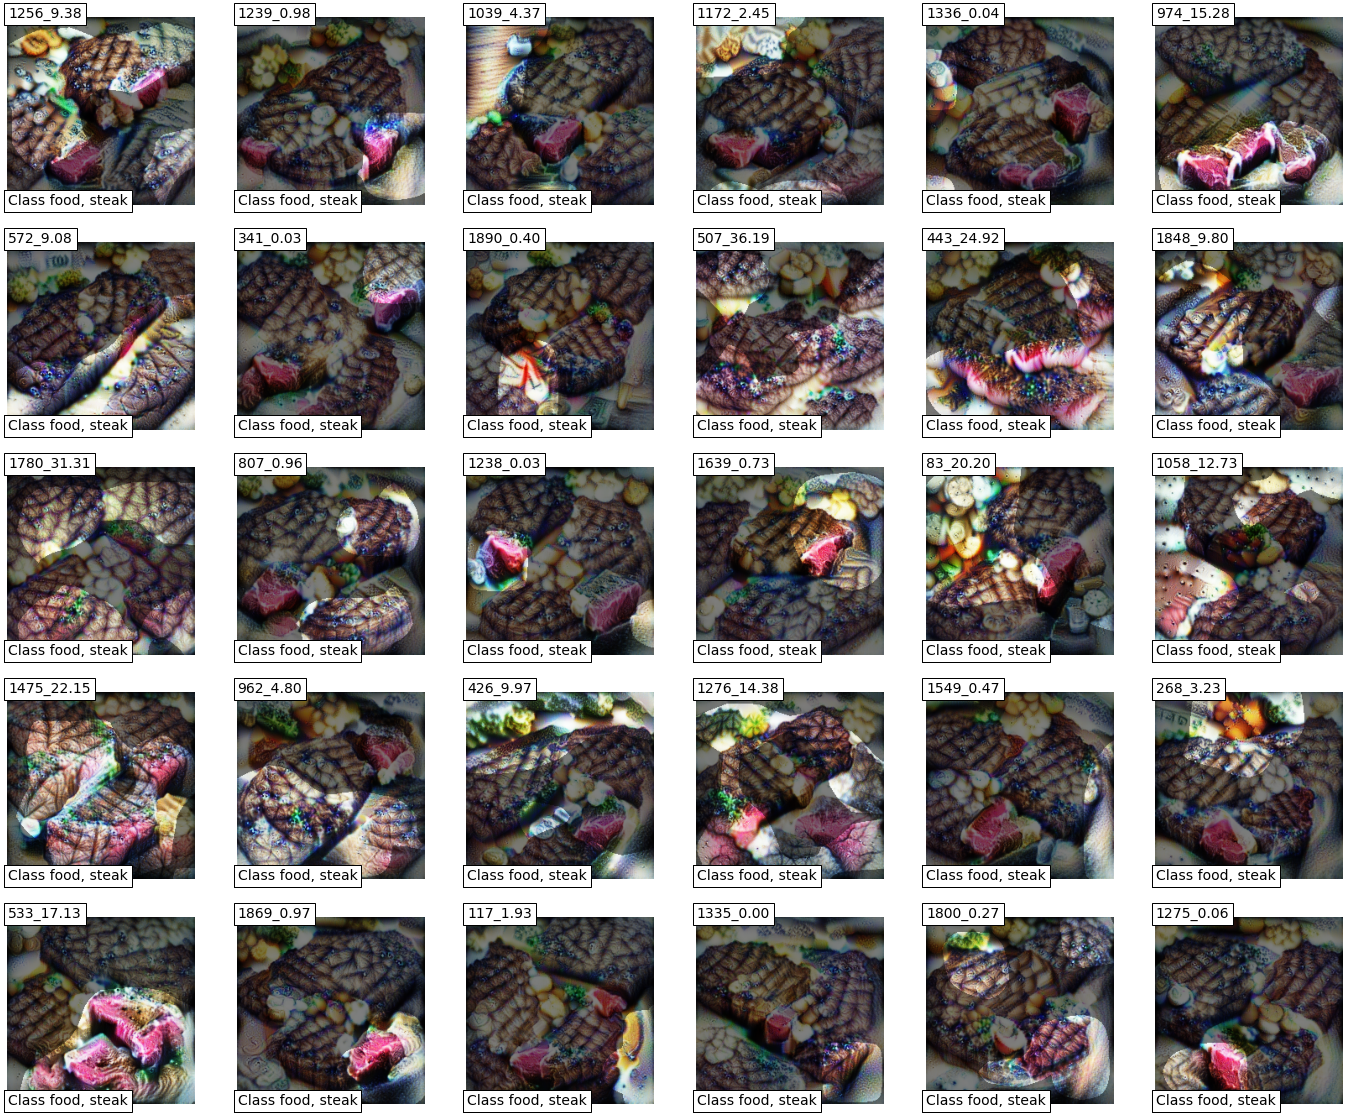

In [11]:
import matplotlib.pyplot as plt
from utils.ops import to_rgb
from PIL import Image

_images = to_rgb((images).cpu().detach()) # (masks+0.5).clamp(max=1.0)
_acts = acts.cpu().detach().numpy()
neurons = target_neurons.tolist()

pil_images = [Image.fromarray(_images[i], "RGB") for i in range(len(neurons))]

nrows = 1
ncols = len(pil_images)
if len(pil_images) / 6 > 1:
    nrows = int(len(pil_images) / 6)
    ncols = 6

fig, axes = plt.subplots(nrows,ncols)

fig.set_figheight(4*nrows)
fig.set_figwidth(4*ncols)

if nrows==1:
    for i in range(len(neurons)):
        axes[i].imshow(pil_images[i]);
        axes[i].axis(False);
        axes[i].text(0.5, 0.5, "%d_%.2f" % (neurons[i], _acts[i]), fontsize=14, bbox=dict(facecolor="white"));
        axes[i].text(0.5, 224, "Class "+class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
        axes[i].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));
else:
    for i in range(len(neurons)):
        axes[i//ncols, i%ncols].imshow(pil_images[i]);
        axes[i//ncols, i%ncols].axis(False);
        axes[i//ncols, i%ncols].text(0.5, 0.5, "%d_%.2f" % (neurons[i], _acts[i]), fontsize=14, bbox=dict(facecolor="white"));
        axes[i//ncols, i%ncols].text(0.5, 224, "Class "+class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
        axes[i//ncols, i%ncols].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));